In [181]:
import seaborn as sns
import pandas as pd
import numpy as np
import json
import glob
import re
import matplotlib.pyplot as plt
import math
import tqdm
import matplotlib.dates as mdates
import matplotlib as mpl
import sys
sns.set(font_scale=0.9, style='whitegrid', font='CMU Sans Serif')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.figsize'] = (4.5,3)
mpl.rcParams['figure.dpi'] = 100

pd.set_option('mode.chained_assignment', None)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def save_fig(ax, name, file_type="pdf"):
    fig = ax.get_figure()
    fig.tight_layout()
    file_name = name + "." + file_type
    fig.savefig(os.path.join("graphs", file_name), bbox_inches='tight')

In [182]:
async_folder = "logs/18_N"
sync_folder = "logs/13_J"

experiment_phase_ms = {
    "begin": 0,
    "high_end": 600_000,
    "line_end": 1_200_000,
    "end": 1_800_000
}

__color_palette = sns.color_palette("colorblind", 10)
color_map = {
    "async": __color_palette[0],
    "sync": __color_palette[1],
    "cpu": __color_palette[2],
    "check": __color_palette[3],
    "virus": __color_palette[4],
    "ocr": __color_palette[5],
    "email": __color_palette[6],
}

In [197]:
def get_experiment_dfs(folder, experiment):
    call_lines = []
    k6_durations = []
    for file_name in glob.glob("*.log", root_dir=folder):
        with open(folder + "/" + file_name) as f:
            while line := f.readline():
                if "PFSTT" in line and "dashboard is deleting returned header" not in line:
                    json_string = re.search(r'PFSTT(.*?)TTSFP', line).group(1)
                    try:
                        call_lines.append(json.loads(json_string))
                    except:
                        print("Error in file: " + file_name)
                        print("Line: " + line)
                        print("JSON: " + json_string)
                        print("-----")
                        continue
                if "K6MAGICSTRING" in line:
                    raw_data = re.search(r'K6MAGICSTRING(.*?)K7MAGICSTRING', line).group(1)
                    splits = raw_data.split(",")
                    req_duration = float(splits[2].strip())
                    callid = splits[1].strip()
                    start_unix = float(splits[0].strip())
                    k6_durations.append({
                        "start_unix": start_unix,
                        "req_duration_ms": req_duration,
                        "callid": callid,
                    })
    invocation_df = pd.DataFrame(call_lines)
    k6_df = pd.DataFrame(k6_durations)

    first_call_ms = k6_df["start_unix"].min()
    last_finished_ms = invocation_df["end"].max()

    # Start cleaning up the existing DFs, starting with invocaiton_df
    # set data types to float for all numeric columns
    invocation_df = invocation_df.astype({
        "start": float,
        "end": float,
        "request_timestamp": float,
        "request_deadline": float,
    })
    invocation_df["experiment"] = experiment
    invocation_df["start_ms"] = invocation_df["start"] - first_call_ms
    invocation_df["end_ms"] = invocation_df["end"] - first_call_ms
    invocation_df["request_timestamp_ms"] = invocation_df["request_timestamp"] - first_call_ms
    invocation_df["request_deadline_ms"] = invocation_df["request_deadline"] - first_call_ms
    invocation_df["duration_ms"] = invocation_df["end_ms"] - invocation_df["start_ms"]

    # Now clean k6_df
    k6_df["start_ms"] = k6_df["start_unix"] - first_call_ms
    # ...rest should already be cleaned
    k6_df["end_ms"] = k6_df["start_ms"] + k6_df["req_duration_ms"]

    if len(k6_df["callid"].unique()) != len(invocation_df["callid"].unique()):
        print("Mismatched callids", file=sys.stderr)
        #return None


    def process_calls_with_callid(callid):
        k6_req = k6_df[k6_df["callid"] == callid]
        calls = invocation_df[invocation_df["callid"] == callid]
        if len(calls) != 4:
            print(f"Call {callid} has {len(calls)} calls in experiment {experiment}", file=sys.stderr)
            return None
        if len(k6_req) != 1:
            print(f"Call {callid} has {len(k6_req)} k6 requests in experiment {experiment}", file=sys.stderr)
            return None
        start_ms = k6_req["start_ms"].values[0] # when the k6 request started
        end_ms = k6_req["end_ms"].values[0] # when the k6 request ended
        req_duration_ms = k6_req["req_duration_ms"].values[0] # how long the k6 request took according kto k6
        # Now find the run_duration of the call, which is the sum of the durations of the 4 calls
        run_duration_ms = calls["duration_ms"].sum()
        start = k6_req["start_unix"].values[0]
        
        return {
            "callid": callid,
            "experiment": experiment,
            "start": start,
            "start_ms": start_ms,
            "end_ms": end_ms,
            "req_duration_ms": req_duration_ms,
            "run_duration_ms": run_duration_ms,
        }
    
    # Ignore all None values, they are errors
    workflow_df = pd.DataFrame([x for x in map(process_calls_with_callid, k6_df["callid"].unique()) if x is not None])

    # add start_dt, end_dt, request_timestamp_dt, request_deadline_dt, duration_td
    invocation_df["start_dt"] = pd.to_datetime(invocation_df["start_ms"], unit="ms")
    invocation_df["end_dt"] = pd.to_datetime(invocation_df["end_ms"], unit="ms")
    invocation_df["request_timestamp_dt"] = pd.to_datetime(invocation_df["request_timestamp_ms"], unit="ms")
    invocation_df["request_deadline_dt"] = pd.to_datetime(invocation_df["request_deadline_ms"], unit="ms")
    invocation_df["duration_td"] = pd.to_timedelta(invocation_df["duration_ms"], unit="ms")

    # add dt and td columns to workflow_df
    workflow_df["start_dt"] = pd.to_datetime(workflow_df["start_ms"], unit="ms")
    workflow_df["end_dt"] = pd.to_datetime(workflow_df["end_ms"], unit="ms")
    workflow_df["req_duration_td"] = pd.to_timedelta(workflow_df["req_duration_ms"], unit="ms")
    workflow_df["run_duration_td"] = pd.to_timedelta(workflow_df["run_duration_ms"], unit="ms")

    # sort all by start_dt
    invocation_df = invocation_df.sort_values(by="start_dt")
    workflow_df = workflow_df.sort_values(by="start_dt")

    return (invocation_df, workflow_df)

s_i_df, s_w_df = get_experiment_dfs(sync_folder, "sync")
a_i_df, a_w_df = get_experiment_dfs(async_folder, "async")

Call 32ba9c473b4449b596175b204319edce has 2 calls in experiment sync
Call 568d5f0082d3450cb51352e19cbfaac8 has 2 calls in experiment sync
Call fb4021288d6843a69c7e75c059b9b586 has 2 calls in experiment sync
Call 2954ca3f34914434ba0976db8f51af21 has 2 calls in experiment sync
Call 424aa37873b44ec6892b6f35e23f3bb4 has 2 calls in experiment sync
Call ca08fca982ad4939875d686b28aeedb1 has 2 calls in experiment sync
Call 2df66f0ff776420bb4d463cf0f9fbb84 has 2 calls in experiment sync
Call ba1efd98e1f544acbdce82d5edda03d1 has 2 calls in experiment sync
Call 2164309a131a472ab422d70b46f7bb33 has 2 calls in experiment sync
Call 55caf7fdcee44d9e97f4d521361aff32 has 2 calls in experiment sync
Call b93b50497e47450faa75ac248519c918 has 2 calls in experiment sync
Call eff9c564a265425791aad9750806b29e has 2 calls in experiment sync
Call 59ecbe300d714651b93848f1bddf2351 has 2 calls in experiment sync
Call 59fb9faa80ab494895e2df42ad1851d5 has 2 calls in experiment sync
Call 40f0dc9e83734379b11ee1844e773

In [184]:
print(len(s_w_df))
print(len(a_w_df))

1152
144


In [185]:
__smaller_dfs = []
for file_name in glob.glob("*.csv", root_dir="usage/"):
    with open("usage/" + file_name) as f:
        __smaller_dfs.append(pd.read_csv(f))
__usage_df = pd.concat(__smaller_dfs)

def get_cpu_share(start, end, current):
    # get the length of the experiment
    length = end - start
    # get the current time in the experiment
    current = current - start

    # if the current time is in the first third of the experiment
    if current < length/3:
        return "0.80"
    # if the current time is in the last third of the experiment, but not after the experiment
    elif current > 2*length/3 and current < length:
        return "0.15"
    # after the experiment, its 0
    elif current > length:
        return "0.00"
    # if the current time is in the middle third of the experiment
    else:
        # calculate the cpu share based on the current time
        return str(round(((-1.95/length)*current + 1.45), 2))
        # the value if you want to go from 50 to 15:
        # return str(round(((-105/length)*current + 85)/100, 2))

def get_cpu_df_from_i_and_w_df(i_df, w_df, experiment):
    min_relevant_unix = w_df["start"].min()
    max_relevant_unix = i_df["end"].max()
    cpu_df = __usage_df[(__usage_df["unix_time"] >= min_relevant_unix) & (__usage_df["unix_time"] <= max_relevant_unix)]
    cpu_df["time_ms"] = cpu_df["unix_time"] - min_relevant_unix
    
    # add time_ms and time_dt as time since the start of the experiment
    cpu_df["time_ms"] = cpu_df["unix_time"] - min_relevant_unix
    cpu_df["time_dt"] = pd.to_datetime(cpu_df["time_ms"], unit="ms")

    # add what the base cpu share was at the time
    cpu_df["base_cpu_share"] = cpu_df.apply(lambda row: float(get_cpu_share(experiment_phase_ms["begin"], experiment_phase_ms["end"], row["time_ms"])) * 100, axis=1)

    cpu_df["experiment"] = experiment

    # This df has cpu_percent and ram_percent as values between 0 and 100
    return cpu_df

s_c_df = get_cpu_df_from_i_and_w_df(s_i_df, s_w_df, "sync")
a_c_df = get_cpu_df_from_i_and_w_df(a_i_df, a_w_df, "async")
c_df = pd.concat([s_c_df, a_c_df])

In [186]:
# list all columns of s_i_df
print(s_w_df.columns)

Index(['callid', 'experiment', 'start', 'start_ms', 'end_ms',
       'req_duration_ms', 'run_duration_ms', 'start_dt', 'end_dt',
       'req_duration_td', 'run_duration_td'],
      dtype='object')


In [187]:
# generate a rolling df for both u_df and both w_df and for both c_df
__i_df_rollable_cols = ['start_dt', 'request_deadline_ms', 'duration_ms', 'start_ms']

# generate a rolling df for i_df and w_df
r_s_i_df = s_i_df[__i_df_rollable_cols].rolling("20s", on="start_dt").mean()
r_a_i_df = a_i_df[__i_df_rollable_cols].rolling("20s", on="start_dt").mean()

__w_df_rollable_cols = ['start_dt', 'req_duration_ms', 'run_duration_ms', 'start_ms']

r_s_w_df = s_w_df[__w_df_rollable_cols].rolling("20s", on="start_dt").mean()
r_a_w_df = a_w_df[__w_df_rollable_cols].rolling("20s", on="start_dt").mean()

# generate a rolling df for both c_df
__c_df_rollable_cols = ['time_dt', 'cpu_percent', 'ram_percent', 'base_cpu_share']
r_s_c_df = s_c_df[__c_df_rollable_cols].rolling("30s", on="time_dt").mean()
r_a_c_df = a_c_df[__c_df_rollable_cols].rolling("30s", on="time_dt").mean()


In [188]:
#s_w_df_phase_1 = s_w_df[s_w_df["start_ms"] < experiment_phase_ms["high_end"]]
#a_w_df_phase_1 = a_w_df[a_w_df["start_ms"] < experiment_phase_ms["high_end"]]

# Get average CPU Load of s_c_df and a_c_df minus baseline
s_c_df["cpu_percent_minus_baseline"] = s_c_df["cpu_percent"] - s_c_df["base_cpu_share"]
a_c_df["cpu_percent_minus_baseline"] = a_c_df["cpu_percent"] - a_c_df["base_cpu_share"]

s_c_df_phase_3 = s_c_df[(s_c_df["time_ms"] > experiment_phase_ms["line_end"]) & (s_c_df["time_ms"] < experiment_phase_ms["end"])]
a_c_df_phase_3 = a_c_df[(a_c_df["time_ms"] > experiment_phase_ms["line_end"]) & (a_c_df["time_ms"] < experiment_phase_ms["end"])]

print(f"Average CPU Over Baseline during the end phase: async: {a_c_df_phase_3['cpu_percent_minus_baseline'].mean()}, sync: {s_c_df_phase_3['cpu_percent_minus_baseline'].mean()}")

Average CPU Over Baseline during the end phase: async: nan, sync: 28.221778523489935


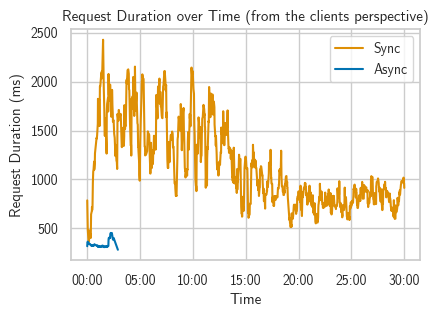

In [189]:
sns.lineplot(data=r_s_w_df, x="start_dt", y="req_duration_ms", label="Sync", color=color_map["sync"])
sns.lineplot(data=r_a_w_df, x="start_dt", y="req_duration_ms", label="Async", color=color_map["async"])
plt.ylabel("Request Duration (ms)")
plt.xlabel("Time")
plt.title("Request Duration over Time (from the clients perspective)")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))

Text(0.5, 1.0, '...overall')

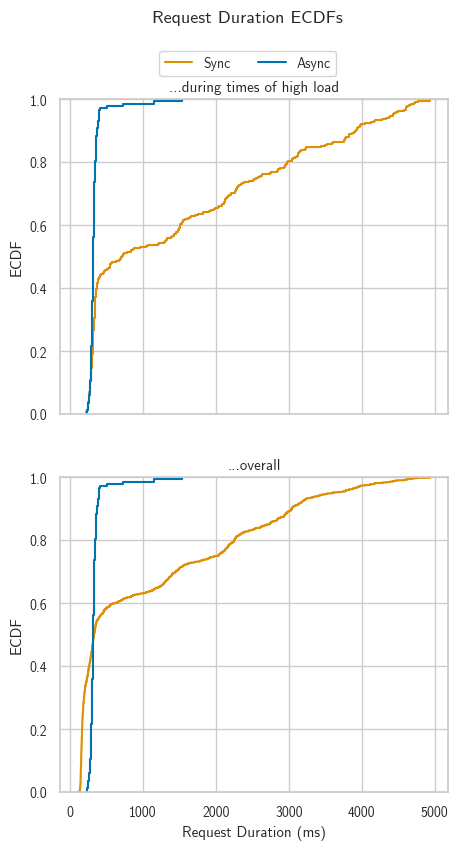

In [190]:
# Create a split ecdf plot with the overall request duration and the request duration during the first phase of the experiment where start_ms is smaller than experiment_phase_ms["high_end"]
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5,9))

sns.ecdfplot(ax=ax2, data=s_w_df, x="req_duration_ms", label="Sync", color=color_map["sync"])
sns.ecdfplot(ax=ax2, data=a_w_df, x="req_duration_ms", label="Async", color=color_map["async"])

# get s_w_df and a_w_df where start_ms is smaller than experiment_phase_ms["high_end"]
s_w_df_phase_1 = s_w_df[s_w_df["start_ms"] < experiment_phase_ms["high_end"]]
a_w_df_phase_1 = a_w_df[a_w_df["start_ms"] < experiment_phase_ms["high_end"]]
sns.ecdfplot(ax=ax1, data=s_w_df_phase_1, x="req_duration_ms", label="Sync", color=color_map["sync"])
sns.ecdfplot(ax=ax1, data=a_w_df_phase_1, x="req_duration_ms", label="Async", color=color_map["async"])

ax1.set_xlabel("")
ax1.set_ylabel("ECDF")
ax2.set_xlabel("Request Duration (ms)")
ax2.set_ylabel("ECDF")

# create one legend for both plots
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='center', ncol=2, bbox_to_anchor=(0.5, 0.92))

# Set overall Title
fig.suptitle("Request Duration ECDFs")
ax1.set_title("...during times of high load")
ax2.set_title("...overall")

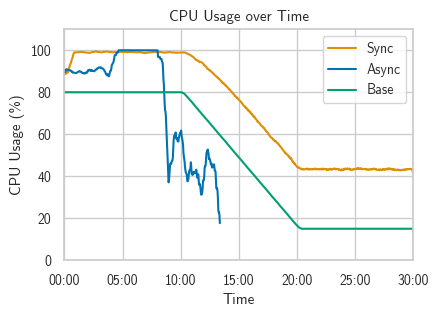

In [191]:
# Plot rolling CPU Usage
sns.lineplot(data=r_s_c_df, x="time_dt", y="cpu_percent", label="Sync", color=color_map["sync"])
sns.lineplot(data=r_a_c_df, x="time_dt", y="cpu_percent", label="Async", color=color_map["async"])
# Plot the base cpu share
sns.lineplot(data=r_s_c_df, x="time_dt", y="base_cpu_share", label="Base", color=color_map["cpu"])
plt.ylabel("CPU Usage (%)")
plt.xlabel("Time")
plt.title("CPU Usage over Time")
plt.xlim(pd.to_datetime(0, unit="ms"),pd.to_datetime(experiment_phase_ms["end"], unit="ms"))
plt.ylim(0,110)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))

Text(0.5, 1.0, 'Workflow Duration over Time (sum of all invocations)')

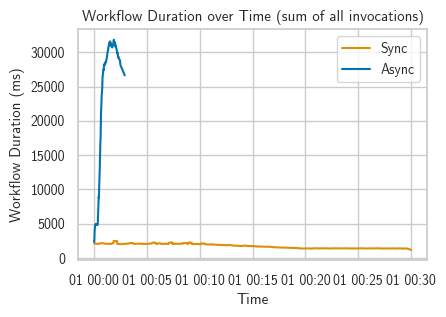

In [192]:
# Plot the total duration of the workflow
sns.lineplot(data=r_s_w_df, x="start_dt", y="run_duration_ms", label="Sync", color=color_map["sync"])
sns.lineplot(data=r_a_w_df, x="start_dt", y="run_duration_ms", label="Async", color=color_map["async"])

plt.ylabel("Workflow Duration (ms)")
plt.xlabel("Time")
plt.title("Workflow Duration over Time (sum of all invocations)")